# Trying headless nets with SVM and LogReg

In [2]:
import os
import time
import shutil
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from functools import partial

from tqdm import tqdm

from matplotlib import pyplot as plt

from keras import backend as K
from keras.preprocessing import image
from keras.applications import VGG19, InceptionV3, ResNet50, Xception
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import Callback, LearningRateScheduler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedShuffleSplit

from skimage.transform import resize


In [3]:
os.chdir('/home/giuliano/git/mo444/lab4/')

## This section contains code related to the trained model I load later on

In [4]:
train_dir = 'data/train/'
test_dir = 'data/test/'
val_dir = 'data/val/'

params = {
    'arch': 'inceptionv3',
    'image_size': (299, 299),
    'receptive_field': (299, 299, 3),
    'batch_size': 32,
    'n_classes': 83,
    'n_epochs': 20,
}

In [6]:
net = None
arch = params['arch'].lower()

if arch == 'vgg19':
    params['image_size'] = (224, 224)
    params['receptive_field'] = (224, 224, 3)

    net = VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=params['receptive_field']
    )
elif arch == 'inceptionv3':
    net = InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=params['receptive_field']
    )
elif arch == 'resnet50':
    params['image_size'] = (224, 224)
    params['receptive_field'] = (224, 224, 3)

    net = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=params['receptive_field']
    )
elif arch == 'xception':
    net = Xception(
        include_top=False,
        weights='imagenet',
        input_shape=params['receptive_field']
    )
else:
    raise ValueError('Architecture name is unknown')


In [ ]:
for layer in net.layers:
    layer.trainable = False

# 12 or 17 is okay for inception
#for layer in net.layers[-12:]:
#    layer.trainable = True

In [8]:
# Keras handles bottleneck models
bottleneck_model = Sequential()

bottleneck_model.add(net)
bottleneck_model.add(GlobalAveragePooling2D())

bottleneck_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


## Using the trained model and its bottleneck
Henceforth:
 - Load the trained model (Inception + GAP + Dense/Softmax)
 - Create a secondary model using only the inner Inception net
 - Try a prediction on both
 - Write the code for prediction over the whole validation set for both models
 - Use this data as input features for two SVMs
 - Evaluate SVMs' predictions
 - Try to combine them and evaluate that instead
 - Try one class SVMs instead, repeat

In [5]:
full_model = load_model('models/model5/inception_v3_spoton.model.h5')

full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_avg_pool (GlobalAvera (None, 2048)              0         
_________________________________________________________________
classifier (Dense)           (None, 83)                170067    
Total params: 21,972,851
Trainable params: 170,067
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# Reference code (Chollet's)
#bottleneck_model = Model(input=base_model.input, output=base_model.get_layer('block4_pool').output)

# This is the Inception v3 network I used to train my current model
net = full_model.layers[0]

# Now we build another model ontop of it for the bottleneck features using a GAP layer
x = GlobalAveragePooling2D()(net.get_layer('mixed10').output) # 310 is the last inception layer
bottleneck_model = Model(net.get_layer('input_1').input, x, name='inception_v3_bottleneck')

# This list is as long as Inception's
bottleneck_model.summary()

`svm_bottleneck` should connect to the output of `bottleneck_model`, thus training based on image features.

`svm_net` should connect to the output of `full_model`, thus training on the output of the deep model.

In [7]:
svm_bottleneck = SVC(
    C=1.0,
    gamma='auto',
    probability=True,
    tol=0.001,
    verbose=False,
    decision_function_shape='ovr'
)

svm_net = SVC(
    C=1.0,
    gamma='auto',
    probability=False,
    tol=0.001,
    verbose=False,
    decision_function_shape='ovr'
)

## Data loading/augmentation
Includes:
 - DataImageGenerators for training and validation
 - Helper function to extract maximum square crops during data augmentation
 - Feature extraction over both training and validation samples

In [8]:
# Because net was trained for imagenet, I should normalise the input using:
# mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
# However, results came even without it, so I am sticking to no normalisation
# until I find it necessary.

def max_square_crop(image, location='random'):
    '''
    Returns a square crop of maximum dimensions within _image_.
    The crop location can be 'random' (default) or 'centre'.
    Yep, centre, fuck America.
    '''
    # Input is a numpy 3D array
    height, width, _ = image.shape
    side = np.min((height, width))
    h_band = height - side
    w_band = width - side
    
    if location == 'centre':
        raise NotImplementedError('Sorry, central crop not implemented yet. Yes, lazy me.')

    rand_row = np.random.randint(0, h_band + 1)
    rand_col = np.random.randint(0, w_band + 1)
    
    square_crop = image[rand_row:(rand_row + side),
                        rand_col:(rand_col + side), :]
    
    return square_crop


preproc_crop = partial(max_square_crop, location='random')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.2,
    preprocessing_function=preproc_crop
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preproc_crop
)

if (os.getcwd()[-4:] != 'lab4'):
    os.chdir('..')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=params['image_size'],
    batch_size=params['batch_size'],
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=params['image_size'],
    batch_size=params['batch_size'],
    class_mode='categorical'
)

Found 8300 images belonging to 83 classes.
Found 6022 images belonging to 83 classes.


/home/giuliano/git/mo444/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


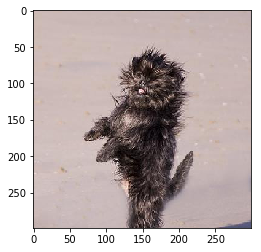

In [40]:
fn = train_generator.filenames[0]

img = plt.imread(os.path.join(train_dir, fn))
label = os.path.dirname(fn)

img = preproc_crop(img)
img = resize(img, params['image_size'], order=0)

plt.imshow(img)

### Use the network bottleneck to generate a feature dataset (train and validation)

In [41]:
# Using no augmentation for SVM, just the features
svm_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=params['image_size'],
    batch_size=1, #params['batch_size']
    class_mode='categorical'
)

samples_per_class = 100
batch_size = 1 #params['batch_size']
n_epochs = int(np.ceil(samples_per_class * params['n_classes'] / batch_size))
#train_x = np.empty((0, 2048))
#train_y = np.empty((0, 83))

train_x = []
train_y = []

for fn in tqdm(svm_generator.filenames):
    img = plt.imread(os.path.join(train_dir, fn))
    label = os.path.dirname(fn)
    
    img = preproc_crop(img)
    img = resize(img, params['image_size'], order=0)
    #img /= 255.
    
    img_feats = bottleneck_model.predict(np.expand_dims(img, axis=0))
    
    train_x.append(img_feats)
    train_y.append(label)

'''
for epoch in tqdm(range(n_epochs)):
    batch, labels = svm_generator.next()
    batch_features = bottleneck_model.predict_on_batch(batch)
    
    train_x = np.append(train_x, batch_features, axis=0)
    train_y = np.append(train_y, labels, axis=0)
'''

train_x = np.array([x.flatten() for x in train_x])
train_y = np.array([int(x) for x in train_y])

print('done')
#train_x.shape, train_y.shape
len(train_x), len(train_y)

Found 8300 images belonging to 83 classes.


  0%|          | 0/8300 [00:00<?, ?it/s]/home/giuliano/git/mo444/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 8300/8300 [05:15<00:00, 26.30it/s]


done


(8300, 8300)

In [42]:
# Using no augmentation for SVM, just the features
svm_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=params['image_size'],
    batch_size=1, #params['batch_size']
    class_mode='categorical'
)

samples_per_class_val = 73
n_epochs = int(np.ceil(samples_per_class_val * params['n_classes'] / params['batch_size']))
#val_x = np.empty((0, 2048))
#val_y = np.empty((0, 83))

val_x = []
val_y = []

for fn in tqdm(svm_generator.filenames):
    img = plt.imread(os.path.join(val_dir, fn))
    label = os.path.dirname(fn)
    
    img = preproc_crop(img)
    img = resize(img, params['image_size'], order=0)
    #img /= 255.
    
    img_feats = bottleneck_model.predict(np.expand_dims(img, axis=0))
    
    val_x.append(img_feats)
    val_y.append(label)

'''
for epoch in tqdm(range(n_epochs)):
    batch, labels = svm_generator.next()
    batch_features = bottleneck_model.predict_on_batch(batch)
    
    val_x = np.append(val_x, batch_features, axis=0)
    val_y = np.append(val_y, labels, axis=0)
'''

val_x = np.array([x.flatten() for x in val_x])
val_y = np.array([int(x) for x in val_y])

print('done')
#val_x.shape, val_y.shape
len(val_x), len(val_y)

Found 6022 images belonging to 83 classes.


  0%|          | 0/6022 [00:00<?, ?it/s]/home/giuliano/git/mo444/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 6022/6022 [03:45<00:00, 26.71it/s]

done


(6022, 6022)

In [ ]:
# old code for old generator loop
'''
train_1hot = train_y.copy()
val_1hot = val_y.copy()

train_y = np.argmax(train_y, axis=1)
val_y = np.argmax(val_y, axis=1)

len(train_y), len(train_labels)
'''

### Checking bottleneck features dataset distribution (should be uniform for the train)

Estimated p =  0.012048192771084338


(0.012048192771084338, 0.0)

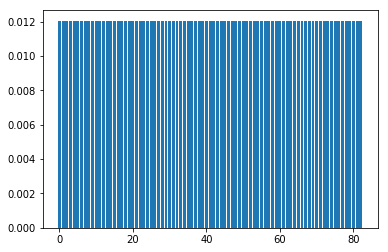

In [43]:
#class_distrib_train = np.array(np.sum(train_1hot, axis=0)).flatten()
class_distrib_train = np.histogram(train_y, bins=np.arange(0, 1 + params['n_classes']))[0]

plt.bar(np.arange(len(class_distrib_train)), class_distrib_train/np.sum(class_distrib_train))
plt.savefig('img/bottleneck_train_distrib.png')
print('Estimated p = ', 1/83)

class_density_train = class_distrib_train / np.sum(class_distrib_train)

np.mean(class_density_train), np.std(class_density_train)

Estimated p =  0.012048192771084338


(0.012048192771084336, 0.003849287576673688)

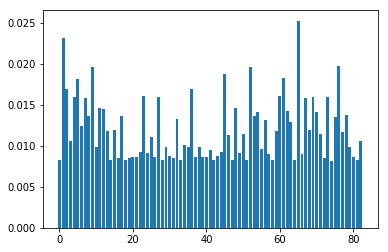

In [44]:
#class_distrib_val = np.array(np.sum(val_1hot, axis=0)).flatten()
class_distrib_val = np.histogram(val_y, bins=np.arange(0, 1 + params['n_classes']))[0]

plt.bar(np.arange(len(class_distrib_val)), class_distrib_val/np.sum(class_distrib_val))
plt.savefig('img/bottleneck_val_distrib.png')
print('Estimated p = ', 1/83)

class_density_val = class_distrib_val / np.sum(class_distrib_val)

np.mean(class_density_val), np.std(class_density_val)

In [45]:
np.savez('models/bottleneck_datasets.npz', train_x, train_y, val_x, val_y)

## Training the SVMs

### Load dataset (in case of a cold start)

In [19]:
data = np.load('models/bottleneck_datasets.npz')

train_x = data['arr_0']
train_y = data['arr_1']
val_x = data['arr_2']
val_y = data['arr_3']

train_x.shape, train_y.shape, val_x.shape, val_y.shape

((8300, 2048), (8300,), (6022, 2048), (6022,))

### Dimensionality reduction (in case 2048 features is too much) via PCA and LDA

In [46]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [88]:
# 95% energy was in 600 dimensions or so
pca = PCA(n_components=600)

pca.fit(train_x)

PCA(copy=True, iterated_power='auto', n_components=600, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

(0.9504769, 2048)

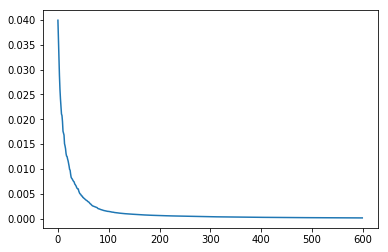

In [64]:
n_feats = 600

plt.plot(range(len(pca.explained_variance_ratio_[:n_feats])), pca.explained_variance_ratio_[:n_feats])

np.sum(pca.explained_variance_ratio_[:n_feats]), len(pca.explained_variance_)

In [87]:
# 95% of energy in 68 dimensions or so
lda = LinearDiscriminantAnalysis(n_components=68)

lda.fit(train_x, train_y)

LinearDiscriminantAnalysis(n_components=68, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

(0.9522358786282047, 82)

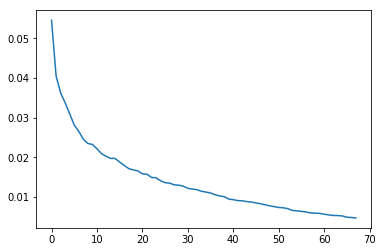

In [86]:
n_feats = 68

plt.plot(range(len(lda.explained_variance_ratio_[:n_feats])), lda.explained_variance_ratio_[:n_feats])

np.sum(lda.explained_variance_ratio_[:n_feats]), len(lda.explained_variance_ratio_)

In [105]:
train_x_pca = pca.transform(train_x)
train_x_lda = lda.transform(train_x)

train_x_pca.shape, train_x_lda.shape

((8300, 600), (8300, 68))

### SVM 5-fold Crossvalidation w/ acc and f1 (all features, pca or lda)

In [96]:
# f1_micro, f1_macro, f1_weighted
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro'}

svm_bottleneck = SVC(
    C=1.0,
    gamma='auto',
    probability=True,
    tol=0.001,
    verbose=False,
    decision_function_shape='ovr'
)

'''
svm_bottleneck = LinearSVC(
    penalty='l2',
    loss='squared_hinge',
    tol=0.0001,
    C=1.0,
    multi_class='ovr',
    verbose=0,
    max_iter=1000
)
'''

t0 = time.time()
scores = cross_validate(svm_bottleneck, train_x, train_y, scoring=scoring, cv=5, return_train_score=True, n_jobs=3, verbose=1)
# with dimensionality reduction
#scores = cross_validate(svm_bottleneck, train_x_pca, train_y, scoring=scoring, cv=5, return_train_score=True, n_jobs=3, verbose=1)
#scores = cross_validate(svm_bottleneck, train_x_lda, train_y, scoring=scoring, cv=5, return_train_score=True, n_jobs=3, verbose=1)

print('finished in %.2fs' % (time.time() - t0))

print('Models took an average %ds to train and another %ds to score' % (np.mean(scores['fit_time']), np.mean(scores['score_time'])))
print('Average accuracy was %.3f +- %.3f during training' % (np.mean(scores['train_accuracy']), np.std(scores['train_accuracy'])))
print('Average accuracy was %.3f +- %.3f during testing' % (np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))
print('Average F1 was %.3f +- %.3f during training' % (np.mean(scores['train_f1']), np.std(scores['train_f1'])))
print('Average F1 was %.3f +- %.3f during testing' % (np.mean(scores['test_f1']), np.std(scores['test_f1'])))

finished in 1133.87s
Models took an average 331s to train and another 47s to score
Average accuracy was 0.954 +- 0.001 during training
Average accuracy was 0.943 +- 0.006 during testing
Average F1 was 0.954 +- 0.001 during training
Average F1 was 0.942 +- 0.006 during testing


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed: 18.9min finished


### RBF SVM XVal results (5 fold, 3 threads)

#### **LDA (68 features) [BEST]**
- finished in 69.03s
- Models took an average 21s to train and another 2s to score
- Average accuracy was 0.996 +- 0.001 during training
- Average accuracy was 0.971 +- 0.003 during testing
- Average F1 was 0.996 +- 0.001 during training
- Average F1 was 0.971 +- 0.003 during testing

#### PCA (600 features)
- finished in 263.25s
- Models took an average 65s to train and another 13s to score
- Average accuracy was 0.966 +- 0.002 during training
- Average accuracy was 0.945 +- 0.004 during testing
- Average F1 was 0.966 +- 0.002 during training
- Average F1 was 0.944 +- 0.004 during testing

#### No reduction
- finished in 1133.87s
- Models took an average 331s to train and another 47s to score
- Average accuracy was 0.954 +- 0.001 during training
- Average accuracy was 0.943 +- 0.006 during testing
- Average F1 was 0.954 +- 0.001 during training
- Average F1 was 0.942 +- 0.006 during testing

### Linear SVM XVal results (5 fold, 3 threads)

#### **LDA (68 features) [BEST]**
- finished in 27.52s
- Models took an average 13s to train and another 0s to score
- Average accuracy was 0.994 +- 0.001 during training
- Average accuracy was 0.973 +- 0.005 during testing
- Average F1 was 0.994 +- 0.001 during training
- Average F1 was 0.973 +- 0.005 during testing

#### PCA (600 features)
- finished in 66.86s
- Models took an average 33s to train and another 0s to score
- Average accuracy was 1.000 +- 0.000 during training
- Average accuracy was 0.926 +- 0.005 during testing
- Average F1 was 1.000 +- 0.000 during training
- Average F1 was 0.926 +- 0.005 during testing

#### No reduction
- finished in 70.06s
- Models took an average 35s to train and another 0s to score
- Average accuracy was 1.000 +- 0.000 during training
- Average accuracy was 0.935 +- 0.005 during testing
- Average F1 was 1.000 +- 0.000 during training
- Average F1 was 0.935 +- 0.005 during testing

## le SVM train (RBF for probs, LDA feats)

In [ ]:
from keras.utils import plot_model
plot_model(bottleneck_model, to_file='inceptionv3_notop.png')
plot_model(full_model, to_file='inceptionv3_full.png')

In [ ]:
net.summary()

In [115]:
'''
svm_bottleneck = SVC(
    C=1.0,
    gamma='auto',
    probability=True,
    tol=0.001,
    verbose=False,
    decision_function_shape='ovr'
)
'''
svm_bottleneck = LinearSVC(
    penalty='l2',
    loss='squared_hinge',
    tol=0.0001,
    C=1.0,
    multi_class='ovr',
    verbose=0,
    max_iter=1000
)


t0 = time.time()
#svm_bottleneck.fit(train_x_lda, train_y) # 86 89
svm_bottleneck.fit(train_x_pca, train_y) # 95 94
#svm_bottleneck.fit(train_x, train_y) # 94 94
print('finished in %.1fs' % (time.time() - t0))

#val_x_lda = lda.transform(val_x)
#svm_preds = svm_bottleneck.predict(val_x_lda)
val_x_pca = pca.transform(val_x)
svm_preds = svm_bottleneck.predict(val_x_pca)
#svm_preds = svm_bottleneck.predict(val_x)

accuracy_score(val_y, svm_preds), f1_score(val_y, svm_preds, average='macro')

finished in 27.5s


(0.9302557289936898, 0.9254161237188564)

In [ ]:
'''
cv = 5
scores = {
    'fit_time' = [],
    'train_accuracy' = [0],
    'test_accuracy' = [],
    'train_f1' = [0],
    'test_f1' = [],
}
classifiers = []
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

t0 = time.time()

for train_idx, val_idx in sss.split(train_x, train_y):
    Xt, yt = train_x[train_idx], train_y[train_idx]
    Xv, yv = val_x[val_idx], val_y[val_idx]
    
    cls = SVC(
        C=1.0, gamma='auto',
        probability=True,
        tol=0.001, verbose=False,
        decision_function_shape='ovr'
    )
    
    t0 = time.time()
    cls.fit(Xt, yt)
    train_time = time.time() - t0
    
    cls_tpreds = cls.predict(Xv)
    cls_acc = accuracy_score(yv, cls_preds)
    cls_f1 = f1_score(yv, cls_preds, average='macro')
    
    scores['fit_time'].append(train_time)
    scores['test_accuracy'].append(cls_acc)
    scores['test_f1'].append(cls_f1)
'''

#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5)
#for 

In [278]:
# fit on train data
t0 = time.time()
svm_bottleneck.fit(train_x, train_y)
print('finished in %.2fs' % (time.time() - t0))

finished in 424.39s


In [279]:
t0 = time.time()
preds = svm_bottleneck.predict(val_x)
print('finished in %.2fs' % (time.time() - t0))

finished in 132.46s


In [282]:
t0 = time.time()
preds_prob = svm_bottleneck.predict_proba(val_x)
print('finished in %.2fs' % (time.time() - t0))

finished in 136.37s


In [286]:
preds_prob[0]

array([0.00284991, 0.00257874, 0.00213553, 0.00470087, 0.00294736,
       0.00295121, 0.00193655, 0.00099957, 0.00174083, 0.00150259,
       0.00188458, 0.00126948, 0.00301752, 0.00130223, 0.00177268,
       0.00406965, 0.00253043, 0.00329443, 0.00236877, 0.00766749,
       0.00477115, 0.00204207, 0.00622745, 0.0049074 , 0.00721435,
       0.00266479, 0.00221388, 0.00177658, 0.00169909, 0.00284939,
       0.00297427, 0.00256683, 0.00284138, 0.00649074, 0.00333738,
       0.00175484, 0.00194171, 0.00318364, 0.00313523, 0.01438967,
       0.00322329, 0.00296094, 0.00182582, 0.0013066 , 0.0134804 ,
       0.00126216, 0.00279906, 0.00339908, 0.00690571, 0.00178551,
       0.00429368, 0.00221464, 0.00413542, 0.00216499, 0.00181059,
       0.00192824, 0.00253742, 0.00223066, 0.00302232, 0.00303709,
       0.00251439, 0.0092489 , 0.00296002, 0.00275809, 0.73455844,
       0.0019207 , 0.00200178, 0.00207657, 0.00359526, 0.00706717,
       0.002811  , 0.00162065, 0.0029259 , 0.00160498, 0.00233

In [227]:
# test on validation data
t0 = time.time()
preds = svm_bottleneck.predict(val_x)
print('finished in %.2fs' % (time.time() - t0))

t0 = time.time()
acc = accuracy_score(val_y, preds)
print('finished in %.2fs' % (time.time() - t0))

t0 = time.time()
f1 = f1_score(val_y, preds, average='macro')
print('finished in %.2fs' % (time.time() - t0))

acc, f1

finished in 132.25s
finished in 0.00s
finished in 0.00s


(0.9225210758731434, 0.9228099555159774)

In [275]:
# saving a backup of the previously trained svm just in case
svm_bottleneck_bottleneck = svm_bottleneck

## Test set

In [156]:
testdf = pd.read_csv('data/MO444_dogs_test.txt', sep=' ', names=('original_filename', 'hashed_filename', 'label_idx'))

#testdf

In [157]:
for idx in testdf.index:
    hashed_fn = testdf.iloc[idx]['hashed_filename']
    testdf.at[idx, 'hashed_filename'] = '/'.join(hashed_fn.split('/')[-1:])

#testdf

In [158]:
for idx in testdf.index:
    original_fn = testdf.iloc[idx]['original_filename']
    testdf.at[idx, 'original_filename'] = original_fn.split('/')[3].split('.')[1]

#testdf

In [159]:
testdf.columns = ['label', 'hashed_filename', 'label_idx']

In [160]:
filenames = list(np.array(testdf['hashed_filename']))

In [168]:
#labels = np.array(testdf['label_idx'])

In [177]:
samples_per_class = 100
batch_size = 1 #params['batch_size']
n_epochs = int(np.ceil(samples_per_class * params['n_classes'] / batch_size))
#train_x = np.empty((0, 2048))
#train_y = np.empty((0, 83))

test_x = []
test_y = np.array(testdf['label_idx'])

for fn in tqdm(filenames):
    img = plt.imread(os.path.join(test_dir, fn))
    
    img = preproc_crop(img)
    img = resize(img, params['image_size'], order=0)
    
    img_feats = bottleneck_model.predict(np.expand_dims(img, axis=0))
    
    test_x.append(img_feats)

'''
for epoch in tqdm(range(n_epochs)):
    batch, labels = svm_generator.next()
    batch_features = bottleneck_model.predict_on_batch(batch)
    
    train_x = np.append(train_x, batch_features, axis=0)
    train_y = np.append(train_y, labels, axis=0)
'''

test_x = np.array([x.flatten() for x in test_x])
test_y = np.array([int(x) for x in test_y])

print('done')
#train_x.shape, train_y.shape
len(test_x), len(test_y)

  0%|          | 0/5420 [00:00<?, ?it/s]/home/giuliano/git/mo444/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 5420/5420 [04:30<00:00, 20.04it/s]

done


(5420, 5420)

In [178]:
svms = [SVC(C=1.0, gamma='auto', probability=True, tol=0.001, verbose=False, decision_function_shape='ovr') for _ in range(3)]

t0 = time.time()
svms[0].fit(train_x_lda, train_y) # 
svms[1].fit(train_x_pca, train_y) # 
svms[2].fit(train_x, train_y)     # 
print('finished in %.1fs' % (time.time() - t0))

test_x_lda = lda.transform(test_x)
test_x_pca = pca.transform(test_x)

lda_preds  = svms[0].predict(val_x_lda)
pca_preds  = svms[1].predict(val_x_pca)
nodr_preds = svms[2].predict(val_x)

print(accuracy_score(val_y, lda_preds), f1_score(val_y, lda_preds, average='macro'))
print(accuracy_score(val_y, pca_preds), f1_score(val_y, pca_preds, average='macro'))
print(accuracy_score(val_y, nodr_preds), f1_score(val_y, nodr_preds, average='macro'))

finished in 509.3s
0.8239787446031219 0.8688594736860151
0.950016605778811 0.947622671445991
0.9456991032879442 0.9434218480184767


## Ensembling (f*** this)

In [ ]:
# RBF SVC variance estimated s^2 = (0.003)^2

def inverse_variance_weighting(predictions, variances):
    if len(predictions) != len(variances):
        print('Precictions-variances mismatch.')
        sys.exit(0)
    
    aa = np.sum(np.divide(predictions, variances))
    bb = 1 / np.sum(variances)
    
    return aa / bb

In [ ]:
voting_clf = VotingClassifier([full_model, svm_bottleneck])

So it remains to:
 - **[DONE]** Save pics relative to class distributions in generated datasets
 - Report crossval of svm classifier
 - Report svm validation stats on fully trained svm
 - **[WORKING]** Combine net and svm results somewhat (using label from svm and probs from net or both as probs)
 - Maybe produce a dataset of all images (using generator w/ no augmentation
 - Standardise feats before training svm
 - Svm ontop of net output (probs)

## Data plotting (training/validation) for the inner net and all else

In [48]:
# load saved data
#historydf = pickle.load('')
with open('models/model5/inception_v3_spoton.historydf.pickle', 'rb') as f:
    historydf = pickle.load(f)

historydf

,loss,val_loss,categorical_accuracy,val_categorical_accuracy
0,1.646185,0.328177,0.656265,0.915809
1,0.634889,0.268416,0.830602,0.920458
2,0.540507,0.298440,0.848675,0.901694
3,0.482357,0.264598,0.853855,0.914646
4,0.440917,0.259387,0.866627,0.918632
5,0.393683,0.286007,0.880000,0.912488
6,0.366481,0.269834,0.884337,0.918466
7,0.337267,0.281216,0.892410,0.914480
8,0.319434,0.285904,0.901928,0.912820
9,0.295072,0.270761,0.906627,0.915643


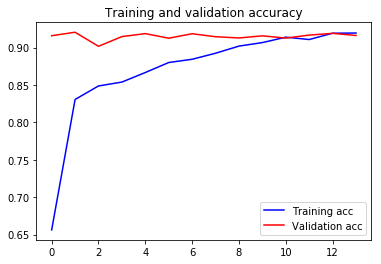

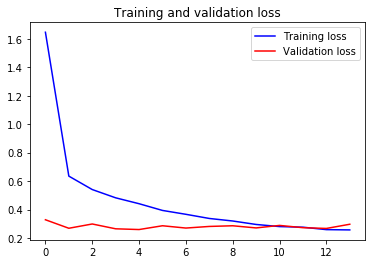

In [50]:
acc = historydf['categorical_accuracy']
val_acc = historydf['val_categorical_accuracy']
loss = historydf['loss']
val_loss = historydf['val_loss']

epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('img/inception_acc.png')

plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('img/inception_loss.png')
 
plt.show()